<font color="blue"><b><h1 style="font-size:4em; font-family:serif"><center>GALACTIC DYNAMO</center></h1></b>

This project is a part of the term project given in course P464 Plamsa Physics and Magnetohydrodynamics taught in Spring 2024 at NISER Bhubaneswar.

Submitted by: <u>Chandan Kumar Sahu</u>, Integrated MSc. SPS batch 19

Supervised by: Dr. Luke R. Chamandy, SPS, NISER

<hr><hr>

<font ><b><h1 style="font-size:3em;"><center>CHAPTER 1</center></h1></b>

# Contents
1. Problem Statement
2. Theory
    1. The mean-field induction equation
    2. Solving in cylindrical coordinates
    3. Calculation of total magnetic field magnitude and pitch angle
    4. Magnetic decay constant
4. Numerical solution to Galactic Magnetic Fields
    1. Solver: Crank-Nicholson
    2. Defining the grid 
    3. Boundary conditions

THE CODE
1. Example 1 - Simplest case ($B_r>0$ and $B_\phi>0$ at all times)
2. Example 2 - ($B_\phi>0$ at all times)
3. Example 3 - Arbitrary seed field

<hr><hr>

# 1.1 - Problem Statement

Solve the diffusion equation in the z-direction.
* Explore the evolution of the magnetic field magnitude and of the exponential decay rate.
* Explore the evolution of the spatial solution for $B_r$ and $B_\phi$, and of the pitch angle of the mean magnetic field p.
* Explore how different boundary conditions affect the results.
* Explore how different seed fields affect the results.

<hr><hr>

# 1.2 - Theory

The dynamo theory describes the process through which a rotating, convecting, and electrically conducting fluid can maintain a magnetic field over astronomical time scales.
The evolution of the magnetic field is described by the induction equation, which relates changes in the magnetic field to the velocity field of the conducting fluid and its magnetic diffusivity. 

In this chapter, we will describe how the galactic magnetic field varies with time in the $z$-direction, and discuss the points mentioned in the problem statement.


## 1.2.1 - The mean-field induction equation

We have the mean-field induction equation as 
$$ \dfrac{\partial \bar{\mathbf{B}}}{\partial t} = \nabla \times \left[ \bar{\mathbf{V}} \times \bar{\mathbf{B}} + \mathcal{E} - \eta \left( \nabla \times \bar{\mathbf{B}} \right) \right] $$
where $\mathcal{E} = \left( \alpha \bar{\mathbf{B}} \right) - \eta_t \left( \nabla \times \bar{\mathbf{B}} \right)$

We will solve the equations in the cylindrical coordinates (r, $\phi$, z) with the origin at the galactic centre and the z-axis parallel to the galactic angular velocity. However, to simplify things, lets make some approximations.

1. Omit the terms involving $\bar{\mathbf{V}} \times \bar{\mathbf{B}}$ and $\alpha$. We will land up on just the diffusion equation.
$$ \dfrac{\partial \bar{\mathbf{B}}}{\partial t} = - \nabla \times \left[ \eta_T \left( \nabla \times \bar{\mathbf{B}} \right) \right] $$
where $\eta_T = \eta + \eta_t$

2. Take $\eta_T$ independent of $\bar{\mathbf{B}}$. Our equation becomes
$$ \dfrac{\partial \bar{\mathbf{B}}}{\partial t} = - \eta_T \left[ \nabla \times \left( \nabla \times \bar{\mathbf{B}} \right) \right] $$
But $\nabla \times \left( \nabla \times \bar{\mathbf{B}} \right) = \nabla \left( \nabla \cdot \bar{\mathbf{B}} \right) - \nabla^2 \bar{\mathbf{B}} $ and $\nabla \cdot \bar{\mathbf{B}} = 0$ (Gauss's Law), so we finally have
$$ \boxed{ \dfrac{\partial \bar{\mathbf{B}}}{\partial t} = \eta_T \nabla^2 \bar{\mathbf{B}} }$$

This is the Fickian diffusion equation. We will solve this equation numerically.
<hr>

## 1.2.2 - Solving in cylindrical coordinates

In cylindrical coordinates, 
$$ \mathbf{\bar{B}} = \bar{B}_r \mathbf{\hat{r}} + \bar{B}_{\phi} \mathbf{\hat{\phi}} + \bar{B}_z \mathbf{\hat{z}} $$

The $\nabla^2B$ becomes
$$ \begin{aligned}
\nabla^2 \mathbf{\bar{B}} = & \left[ \frac{\partial}{\partial r} \left( \frac{1}{r} \frac{\partial}{\partial r} \left( r \bar{B}_r \right) \right) + \frac{1}{r^2} \frac{\partial^2 \bar{B}_r}{\partial \phi^2} + \frac{\partial^2 \bar{B}_r}{\partial z^2} - \frac{2}{r^2} \frac{\partial \bar{B}_\phi}{\partial \phi} \right] \mathbf{\hat{r}} \\
& + \left[ \frac{\partial}{\partial r} \left( \frac{1}{r} \frac{\partial}{\partial r} \left( r \bar{B}_\phi \right) \right) + \frac{1}{r^2} \frac{\partial^2 \bar{B}_\phi}{\partial \phi^2} + \frac{\partial^2 \bar{B}_\phi}{\partial z^2}+\frac{2}{r^2} \frac{\partial \bar{B}_r}{\partial \phi} \right] \mathbf{\hat{\phi}} \\
& + \left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \frac{\partial \bar{B}_z}{\partial r}\right)+\frac{1}{r^2} \frac{\partial^2 \bar{B}_z}{\partial \phi^2}+\frac{\partial^2 \bar{B}_z}{\partial z^2}\right] \mathbf{\hat{z}} 
\end{aligned} $$

So we get the final component-wise equations as
$$ \begin{aligned}
    \frac{\partial \bar{B}_r}{\partial t} &= \eta_T \left[ \frac{\partial}{\partial r} \left( \frac{1}{r} \frac{\partial}{\partial r} \left( r \bar{B}_r \right) \right) + \frac{1}{r^2} \frac{\partial^2 \bar{B}_r}{\partial \phi^2} + \frac{\partial^2 \bar{B}_r}{\partial z^2} - \frac{2}{r^2} \frac{\partial \bar{B}_\phi}{\partial \phi} \right] \\
    \frac{\partial \bar{B}_\phi}{\partial t} &= \eta_T \left[ \frac{\partial}{\partial r} \left( \frac{1}{r} \frac{\partial}{\partial r} \left( r \bar{B}_\phi \right) \right) + \frac{1}{r^2} \frac{\partial^2 \bar{B}_\phi}{\partial \phi^2} + \frac{\partial^2 \bar{B}_\phi}{\partial z^2}+\frac{2}{r^2} \frac{\partial \bar{B}_r}{\partial \phi} \right] \\
    \frac{\partial \bar{B}_z}{\partial t} &= \eta_T \left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \frac{\partial \bar{B}_z}{\partial r}\right)+\frac{1}{r^2} \frac{\partial^2 \bar{B}_z}{\partial \phi^2}+\frac{\partial^2 \bar{B}_z}{\partial z^2}\right] 
\end{aligned} $$

Since the problem statement in the project aims to solve only in the z-direction, we remove all radial or azimuthal variations of the magnetic field $\left(\dfrac{\partial }{\partial r} = \dfrac{\partial }{\partial \phi} = 0 \right)$. 

We are now left with these simple equations to solve, i.e., the Fickian diffusion equations.
$$ \boxed{ \frac{\partial \bar{B}_r}{\partial t} = \eta_T \frac{\partial^2 \bar{B}_r}{\partial z^2} } \qquad \qquad \qquad \boxed{ \frac{\partial \bar{B}_\phi}{\partial t} = \eta_T \frac{\partial^2 \bar{B}_\phi}{\partial z^2} } \qquad \qquad \qquad \boxed{ \frac{\partial \bar{B}_z}{\partial t} = \eta_T \frac{\partial^2 \bar{B}_z}{\partial z^2} } $$

<hr>

## 1.2.3 - Calculation of total magnetic field magnitude ($B_{total}$) and pitch angle ($p_B$)

We can calculate the magnitude of the total magnetic field as 
$$ B_{\text{total}} = \sqrt{\bar{B}_r^2 + \bar{B}_\phi^2} $$
And $$ p_B = \tan^{-1} \left( \dfrac{\bar{B}_r}{\bar{B}_\phi} \right) \qquad \qquad \text{where} \qquad -\dfrac{\pi}{2} < p_B < \dfrac{\pi}{2}$$
<hr>

## 1.2.4 - Magnetic decay constant

The diffusion of the total magnetic field can be expressed in the form

$$ B_{\text{total}}(z, t) = \tilde{B}(r)\exp(\gamma t) $$ 
where $\tilde{B}(r)$ contains all the variation in $r$ and the exponential factor contains time variation, where $\gamma$ is the magnetic decay constant.

Our final goal is to calculate this $\gamma$.
<hr><hr>

# 1.3 - Numerical Solution to Galactic magnetic Fields



Now we begin to solve the diffusion equations numerically.

We will first solve the heat diffusion equation, and use them to calculate the total $B_{\text{total}}$ and the pitch angle $p_B$. Finally we will calculate the decay constant $\gamma$.


## 1.3.1 - Solver: Crank-Nicholson
We use the Crank-Nicholson algorithm to solve the diffusion equation. It combines implicit and explicit schemes, resulting in a stable and accurate solution. 

Let us now get into the details of discretization. Given below is the discretization scheme for the forward Euler explicit method. 

The diffusion equation is given as
$$ \frac{\partial B}{\partial t} = \eta_T \frac{\partial^2 B}{\partial z^2} $$
We use numerical derivative scheme for discretization. The superscript $n$ denotes index in time while the subscript $i$ denotes index in space. $dt$ and $dz$ denote cell thickness in time and space respectively.
$$ \frac{B^{j+1}_{i} - B^{j}_{i}}{dt} = \eta_T \: \frac{B^{j}_{i+1} - 2B^{j}_{i} + B^{j}_{i-1}}{dz^2} $$
This solves to 
$$ B^{j+1}_{i} = B^{j}_{i} + \dfrac{\eta_T dt}{dz^2} \: \left(B^{j}_{i+1} - 2B^{j}_{i} + B^{j}_{i-1} \right) $$
which gives the solution B at the next time-step using the information from the previous time-step. A stencil of forward Euler method is shown below:


Forward Euler Method

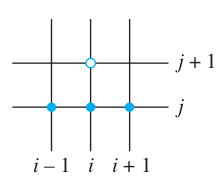



Crank Nicholson Method

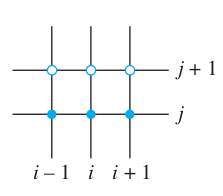


The stability of explicit Euler methods require $\dfrac{\eta_T dt}{dz^2} < 0.5$ which has the disadvantages of instability or high computation power. To overcome this, implicit schemes were developed, which use the information from both previous and present time-step to obtain values at the repsent time-step. 

In this project, we will use the Crank-Nicholson method which uses average of previous and present time-step to solve the problem. Here is the discretization scheme for it. 

$$ \frac{B^{j+1}_{i} - B^{j}_{i}}{dt} = \dfrac{\eta_T}{2} \: \left( \dfrac{B^{j+1}_{i+1} - 2B^{j+1}_{i} + B^{j+1}_{i-1}}{dz^2} \right) + \dfrac{\eta_T}{2} \: \left( \dfrac{B^{j}_{i+1} - 2B^{j}_{i} + B^{j}_{i-1}}{dz^2} \right) $$

Now we separate the present time-step $(j+1)$ and the past time-step $(j)$
$$ B^{j+1}_{i} - \dfrac{\eta_T \: dt}{2 \: dz^2} \: \left( B^{j+1}_{i+1} - 2B^{j+1}_{i} + B^{j+1}_{i-1} \right) = B^{j}_{i} + \dfrac{\eta_T \: dt}{2 \: dz^2} \: \left( B^{j}_{i+1} - 2B^{j}_{i} + B^{j}_{i-1} \right) $$

Taking $\dfrac{\eta_T \: dt}{2 \: dz^2} = \sigma$, we rewrite the equations as 
$$ \left(1+2\sigma \right) B^{j+1}_{i} - \sigma  B^{j+1}_{i+1} - \sigma B^{j+1}_{i-1} = \left(1-2\sigma \right) B^{j}_{i} + \sigma  B^{j}_{i+1} + \sigma B^{j}_{i-1} $$

We can now form a matrix for the two timesteps and solve it.
$$ MB^{j+1} = NB^{j} $$
where
$$ M=\left[\begin{array}{ccccc}1+2 \sigma & -\sigma & 0 & \cdots & 0 \\ -\sigma & 1+2 \sigma & -\sigma & \ddots & \vdots \\ 0 & -\sigma & 1+2 \sigma & \ddots & 0 \\ \vdots & \ddots & \ddots & \ddots & -\sigma \\ 0 & \cdots & 0 & -\sigma & 1+2 \sigma\end{array}\right]     \qquad \qquad      N=\left[\begin{array}{ccccc}1-2 \sigma & \sigma & 0 & \cdots & 0 \\ \sigma & 1-2 \sigma & \sigma & \ddots & \vdots \\ 0 & \sigma & 1-2 \sigma & \ddots & 0 \\ \vdots & \ddots & \ddots & \ddots & \sigma \\ 0 & \cdots & 0 & \sigma & 1-2 \sigma\end{array}\right] $$ 

The final answer i.e., $B^{j+1}$ is obtained as
$$ B^{j+1} = M^{-1}NB^{j} $$


By averaging the values of variables at current and next time steps, it reduces numerical errors and suppresses oscillations. 

The method is highly stable, allowing for larger time steps compared to explicit methods, and is second-order accurate in time and space. This makes it well-suited for simulating heat diffusion processes with high accuracy and efficiency.
<hr>

## 1.3.2 - Defining the grid

### $\star$  Spatial Grid ($z$)

The size of a galactic disk typically ranges from around 10 kpc to 50 kpc. Our Milky way has a radius of ~40 kpc. Within this disk, there are thin and thick disks. The thin disk, where most of the younger stars reside, typically extends from the galactic center to about 100-1000 pc. Meanwhile, the thick disk, containing older stars and having a higher vertical velocity dispersion, can extend further out to ~3 kpc. 

Considering these typical values, we choose the thickness of our model galaxy to be ~200 pc. 

So, $z$ extends from -100 pc to +100 pc. For solving numerically, we normalize the spatial grid to -1 to 1, with a grid cell size of $dz = 0.01$.

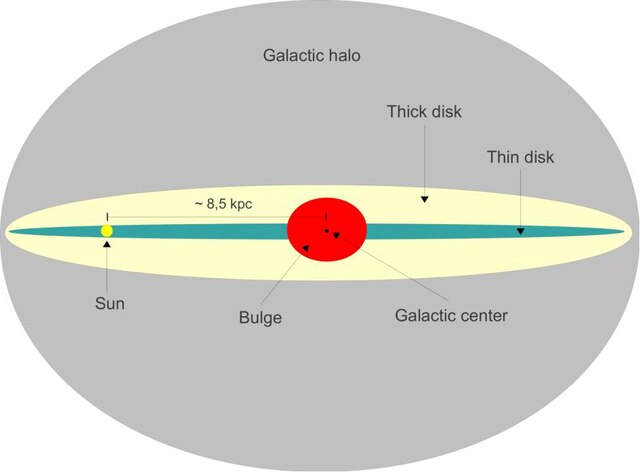
<br>
<font>Figure: Schematic of the Milky Way galaxy

### $\star$  Temporal Grid ($t$)

The typical variation of magnetic fields usually vary in millions of years. 
However, the duration of simulation depends on the seed field, so we change this values and its binning according the the seed field. In general, we take 100 points within the temporal grid range.


### $\star$  Magnetic diffusion coefficient ($\eta_T$)

The magnetic diffusion coefficient measures the rate at which magnetic fields diffuse through a medium. We calculate the value of $\eta_T$ as
$$ \eta_T \approx \dfrac{1}{3} \tau v_{\text{rms}}^2 $$

But we first need to calculate its value in the normlizated units.
For a typical galaxy, the faraday time $\tau \approx 10$ Myr and velocity $v_{\text{rms}} \approx 10^4$ km/s

$$ \begin{aligned}
\eta_T &= \dfrac{1}{3} \times 10 \text{ Myrs} \times (10 \text{ km/s})^2 \\
&= \dfrac{100}{3} \times \text{ Myrs} \times  \dfrac{\text{ km}^2}{\text{s}^2} \\
&= \dfrac{100}{3} \times \text{ Myrs} \times  \left( \dfrac{\text{ km} \times 100 \text{ pc}}{3.086\times 10^{15}\text{ km}} \right)^2 \left(\dfrac{3.154\times 10^{13} \text{ s}}{\text{s} \times \text{Myr}} \right)^2 \\
&= \dfrac{100}{3} \times \left( \dfrac{3.154\times 10^{13}}{3.086\times 10^{15}} \right)^2 \times \text{ (100 pc)}^2/\text{ Myr} \\
&= 3.48 \times 10^{-3}\text{ (100 pc)}^2/\text{ Myr}
\end{aligned} $$

Hence, we use the following values
$$ -1<z<1 \qquad \qquad \text{ with } dz=0.01 \text{ and } \qquad \qquad \eta_T = 3.48 \times 10^{-3}\text{ (100 pc)}^2/\text{ Myr} $$
Here we have $h = 100$ pc
<hr>


## 1.3.3 - Boundary conditions

Two common types of boundary conditions are vacuum boundary conditions and isolated boundary conditions.

#### Vacuum Boundary Conditions (BC):
In vacuum boundary conditions, the system is assumed to be in contact with a perfect vacuum, the boundaries of the system under consideration are devoid of any matter or energy. It ensures that the quantity becomes 0 at the boundaries at all time.

#### Isolated Boundary Conditions:
Isolated boundary conditions imply that the system is completely isolated from its surroundings, meaning there are no exchanges of matter or energy across its boundaries. It ensures that the derivative of the quantity becomes 0 at the boundaries at all time.

We are calculating the diffusion of $B_r$ and $B_\phi$. As the distance in z-increases beyond, $B_z$ dominates over $B_r$. 

Within the thin disk approximation, it is safe to assume that $B_r \rightarrow 0$ as $z \rightarrow 100$ pc. The same thing applies to $B_\phi$ too. Hence, we apply vacuum boundary conditions for all the cases here.


<hr><hr>
<br>
<font ><b><h1 style="font-size:3em; font-family:serif"><center>THE CODE</center></h1></b>

For the full code with al functions and plotting scripts, please visit my <a href="https://github.com/chandan-kumarsahu/Galactic_Dynamo">github repository</a>.

Now let us get into some examples to understand how the magnetic field varies with different types of seed fields.


In [1]:
from my_code import *
from plotting import *

# Example 1

Let us begin with simple seed fields, something which has a central peak and vanishes at the boundary.

### Defining the seed field

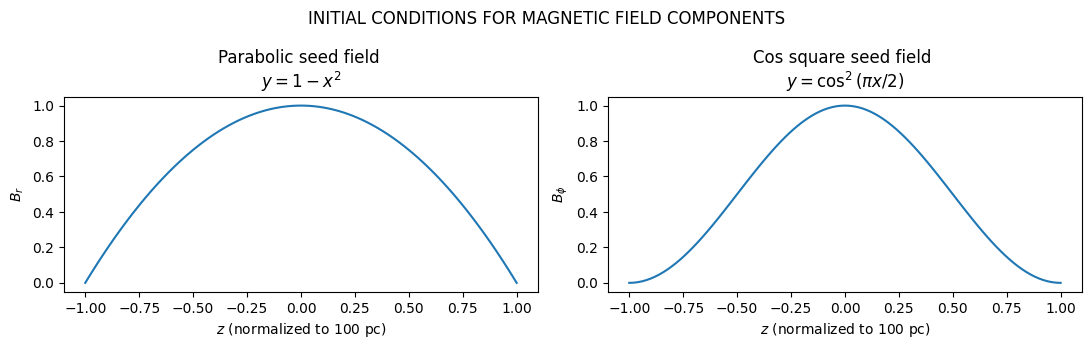

In [2]:
def init_cond_Br(x):
    return 1-x**2

def init_cond_Bphi(x):
    return np.cos(np.pi/2*x)**2

def source_term(x, t):
    return 0

z = np.linspace(-1, 1, 101)
title_1 = r'Parabolic seed field '+'\n'+r'$ y = 1-x^2$'
title_2 = r'Cos square seed field '+'\n'+r'$ y = \cos^2(\pi x/2)$'

plot_init_cond(z, init_cond_Br, init_cond_Bphi, title_1, title_2, global_title='INITIAL CONDITIONS FOR MAGNETIC FIELD COMPONENTS')
plt.show()

### Solving the diffusion equation

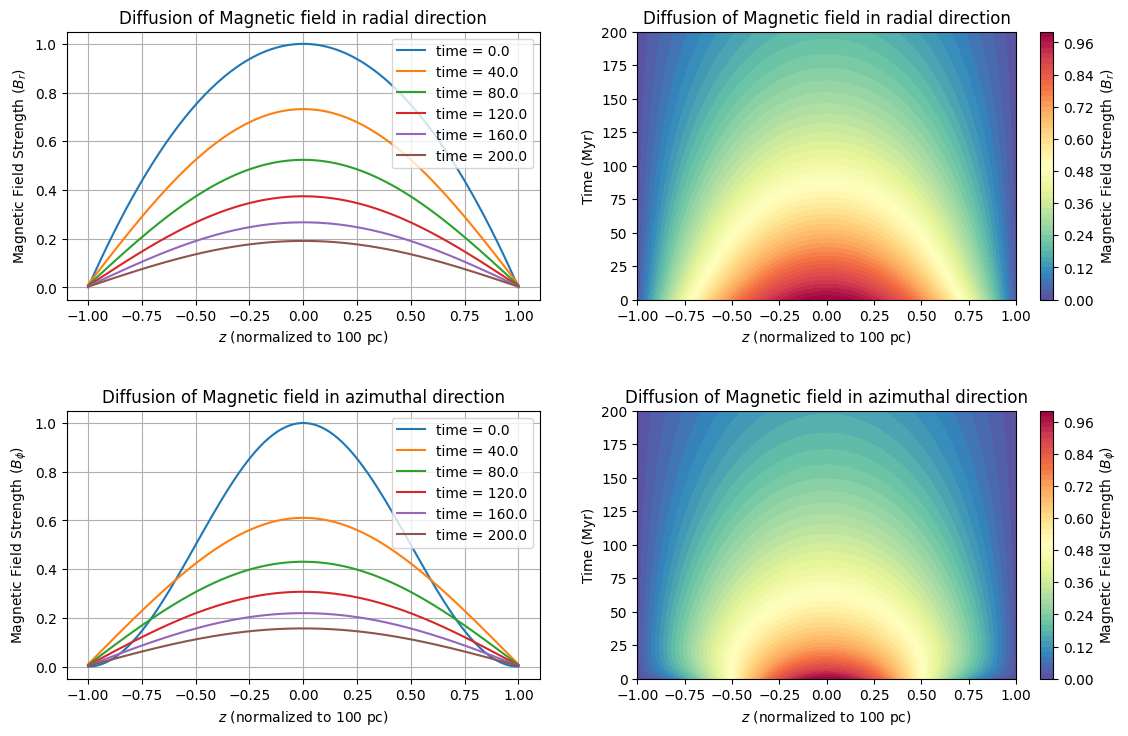

In [3]:
# Constants and parameters
eta_T = 3.48e-3    # magnetic diffusivity
t_max = 200     # total simulation time
z_min = -1.0     # minimum thickness of the disc
z_max = 1.0     # thickness of the disc
dt = t_max/200       # time step
dz = 0.01       # spatial step in z direction

# Solve the diffusion equation in radial direction
solution_r, spatial_grid, time_grid = crank_nicolson_diffusion(z_min, z_max, t_max, dz, dt, eta_T, init_cond_Br, source_term, diff_matrix_vacuum_boundary)
# Solve the diffusion equation in azimuthal direction
solution_phi, spatial_grid, time_grid = crank_nicolson_diffusion(z_min, z_max, t_max, dz, dt, eta_T, init_cond_Bphi, source_term, diff_matrix_vacuum_boundary)

# Plot the diffusion equation solution
plot_diff(time_grid, spatial_grid, solution_r, solution_phi)
plt.show()

# print(time_grid)

### Calculation of $B_{\text{total}}$ and $p_B$


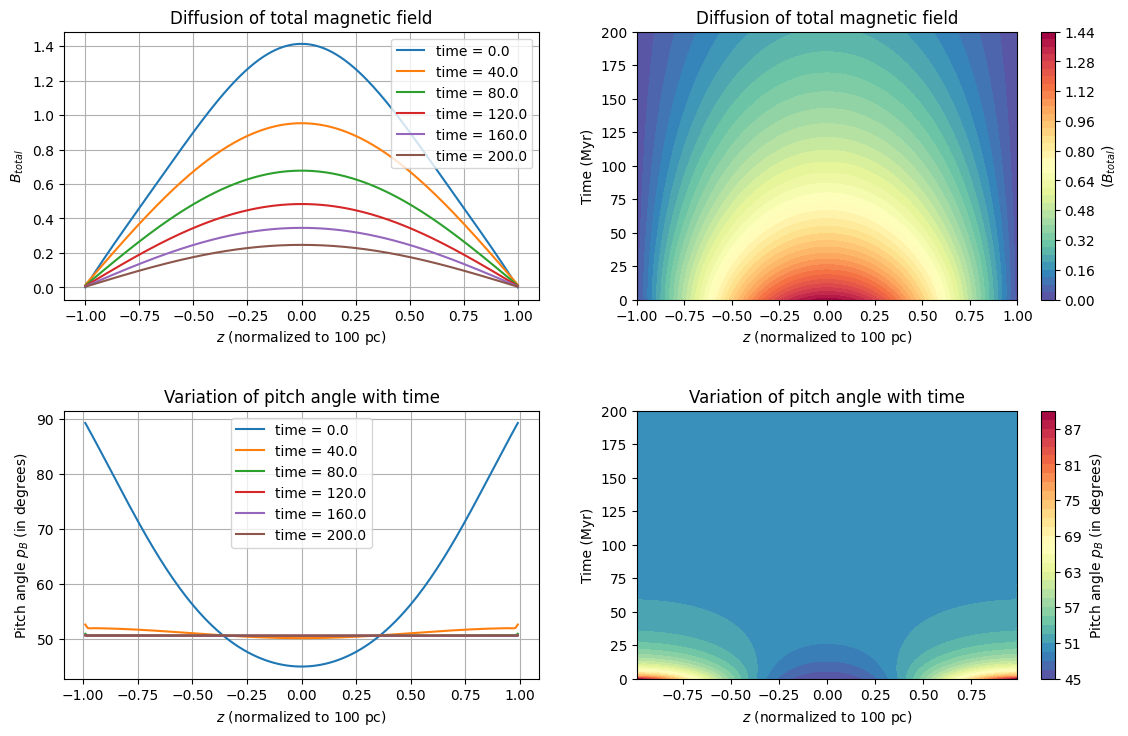

In [4]:
B_total, pitch = get_B_and_pitch(solution_r, solution_phi)

# Plot the total magnetic field and the pitch angle
plot_pitch(time_grid, spatial_grid, B_total, pitch)
plt.show()


### Decay rate calculation

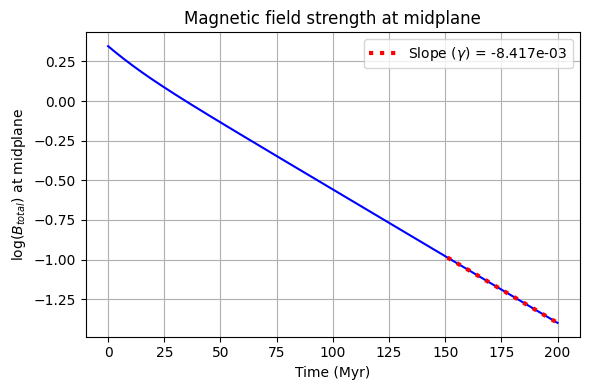

In [5]:
# Plot the decay of the magnetic field at the midplane
B_mid = np.log(B_total[int(len(spatial_grid)/2), :])
m, c = np.polyfit(time_grid[-50:], B_mid[-50:], 1)

plot_decay(time_grid, B_mid, m, c)
plt.show()


So the value of magnetic decay rate or decay constant obtained for this case is $\gamma = -8.417 \times 10^{-3}$

# Example 2

Now we will move to slightly complex seed fields, where the variations and could be arbitrary in both $r$ and $\phi$. However, we have chosen the seed $B_\phi$ to be always positive in this exmaple.

Negative magnitudes correspond to reversal in the direction of the magnetic field.


### Defining the seed field


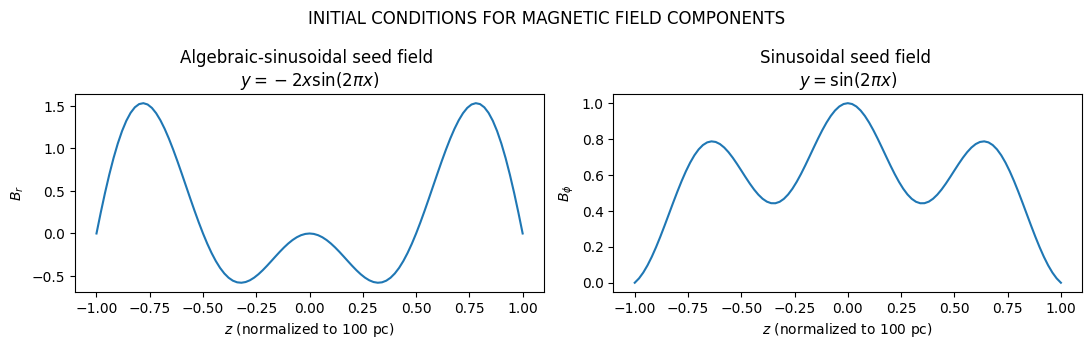

In [6]:
def init_cond_Br(x):
    return -2*x*np.sin(2*np.pi*x)

def init_cond_Bphi(x):
    return 0.75 - 0.5*x**2 + 0.25*np.cos(3*np.pi*x)

def source_term(x, t):
    return 0

z = np.linspace(-1, 1, 101)
title_1 = r'Algebraic-sinusoidal seed field '+'\n'+r'$ y = -2x\sin(2\pi x)$'
title_2 = r'Sinusoidal seed field '+'\n'+r'$ y = \sin(2\pi x)$'

plot_init_cond(z, init_cond_Br, init_cond_Bphi, title_1, title_2, global_title='INITIAL CONDITIONS FOR MAGNETIC FIELD COMPONENTS')
plt.show()


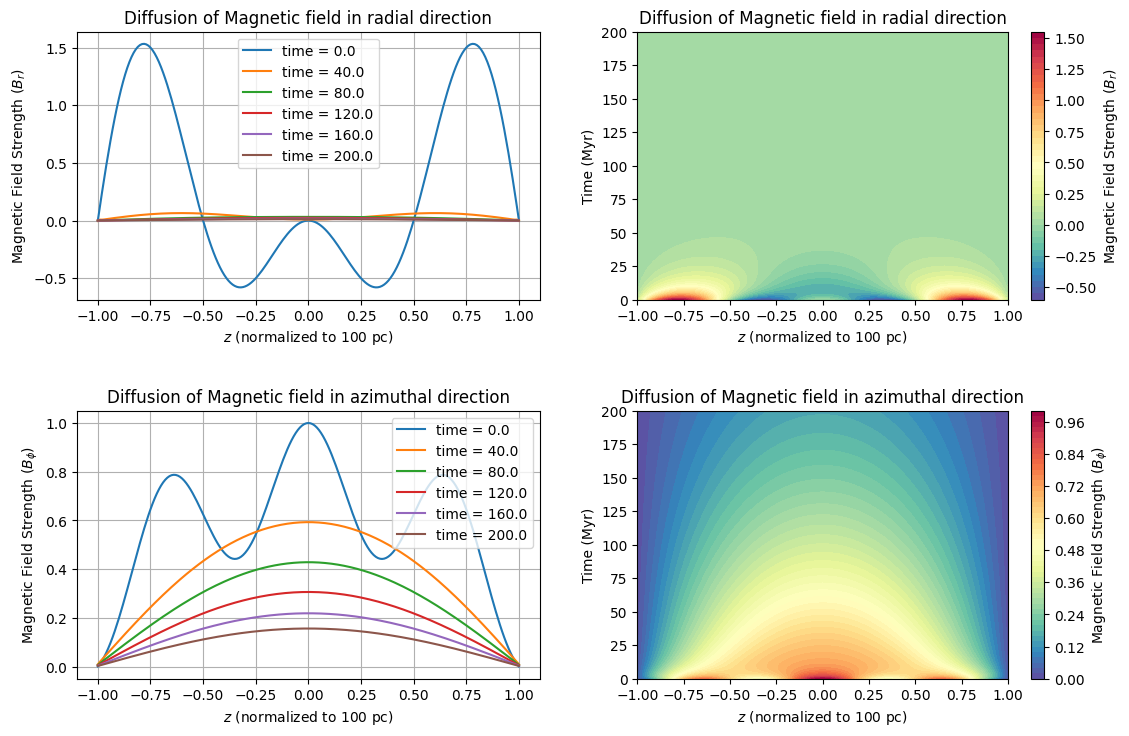

In [7]:
# Constants and parameters
eta_T = 3.48e-3    # magnetic diffusivity
t_max = 200     # total simulation time
z_min = -1.0     # minimum thickness of the disc
z_max = 1.0     # thickness of the disc
dt = t_max/200       # time step
dz = 0.01       # spatial step in z direction

# Solve the diffusion equation in radial direction
solution_r, spatial_grid, time_grid = crank_nicolson_diffusion(z_min, z_max, t_max, dz, dt, eta_T, init_cond_Br, source_term, diff_matrix_vacuum_boundary)
# Solve the diffusion equation in azimuthal direction
solution_phi, spatial_grid, time_grid = crank_nicolson_diffusion(z_min, z_max, t_max, dz, dt, eta_T, init_cond_Bphi, source_term, diff_matrix_vacuum_boundary)

# Plot the diffusion equation solution
plot_diff(time_grid, spatial_grid, solution_r, solution_phi)

plt.show()


### Calculation of $B_{\text{total}}$ and $p_B$


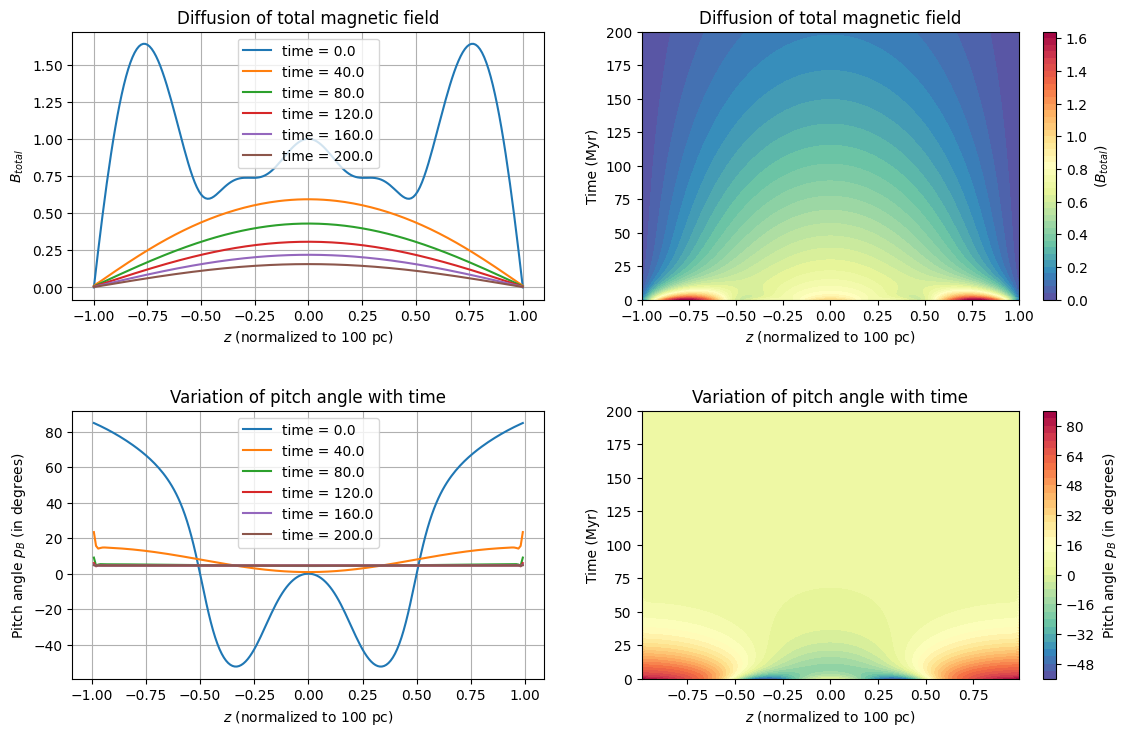

In [8]:
B_total, pitch = get_B_and_pitch(solution_r, solution_phi)

# Plot the total magnetic field and the pitch angle
plot_pitch(time_grid, spatial_grid, B_total, pitch)
plt.show()


### Decay rate calculation

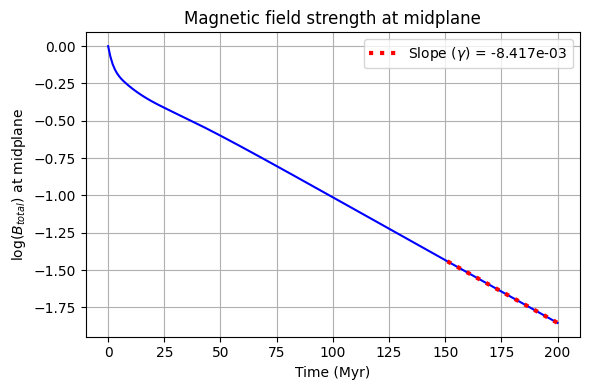

In [9]:
# Plot the decay of the magnetic field at the midplane
B_mid = np.log(B_total[int(len(spatial_grid)/2), :])
m, c = np.polyfit(time_grid[-50:], B_mid[-50:], 1)

plot_decay(time_grid, B_mid, m, c)
plt.show()


So the value of magnetic decay rate or decay constant obtained for this case is $\gamma = -8.417 \times 10^{-3}$

# Example 3

Now let us move to completely arbitrary seed field spanning both positive and negative values.

### Defining the seed field


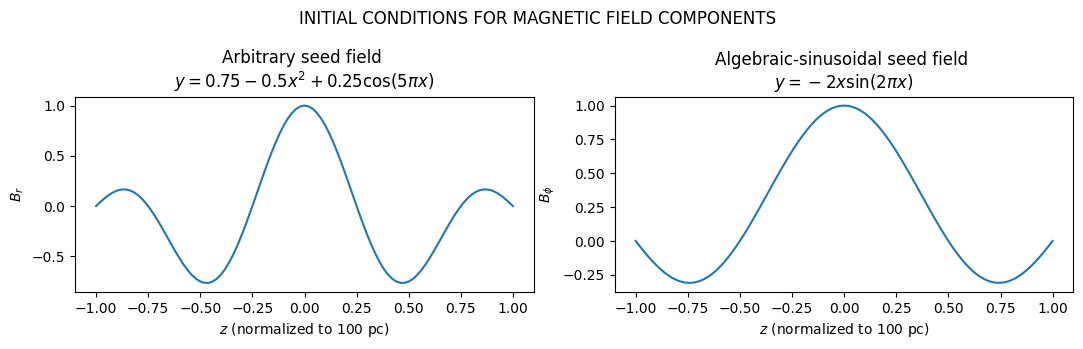

In [10]:
def init_cond_Br(x):
    # return 0.75 - 0.5*x**2 + 0.25*np.cos(5*np.pi*x)
    return (1-x**2)*np.cos(2*np.pi*x)

def init_cond_Bphi(x):
    return (1-x**2)*np.cos(np.pi*x)

def source_term(x, t):
    return 0

z = np.linspace(-1, 1, 101)
title_1 = r'Arbitrary seed field '+'\n'+r'$ y = 0.75 - 0.5x^2 + 0.25\cos(5\pi x)$'
title_2 = r'Algebraic-sinusoidal seed field '+'\n'+r'$ y = -2x\sin(2\pi x)$'

plot_init_cond(z, init_cond_Br, init_cond_Bphi, title_1, title_2, global_title='INITIAL CONDITIONS FOR MAGNETIC FIELD COMPONENTS')
plt.show()


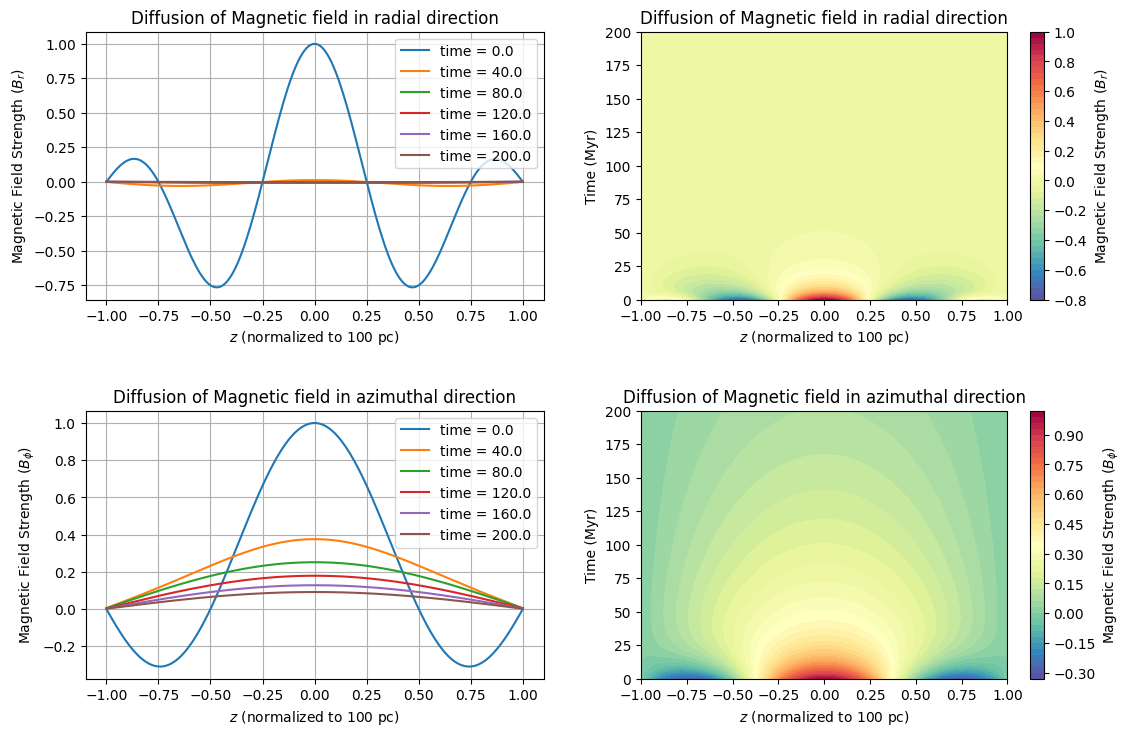

In [11]:
# Constants and parameters
eta_T = 3.48e-3    # magnetic diffusivity
t_max = 200     # total simulation time
z_min = -1.0     # minimum thickness of the disc
z_max = 1.0     # thickness of the disc
dt = t_max/200       # time step
dz = 0.01       # spatial step in z direction

# Solve the diffusion equation in radial direction
solution_r, spatial_grid, time_grid = crank_nicolson_diffusion(z_min, z_max, t_max, dz, dt, eta_T, init_cond_Br, source_term, diff_matrix_vacuum_boundary)
# Solve the diffusion equation in azimuthal direction
solution_phi, spatial_grid, time_grid = crank_nicolson_diffusion(z_min, z_max, t_max, dz, dt, eta_T, init_cond_Bphi, source_term, diff_matrix_vacuum_boundary)

# Plot the diffusion equation solution
plot_diff(time_grid, spatial_grid, solution_r, solution_phi)

plt.show()


### Calculation of magnitude of $B_{total}$ and $p_B$

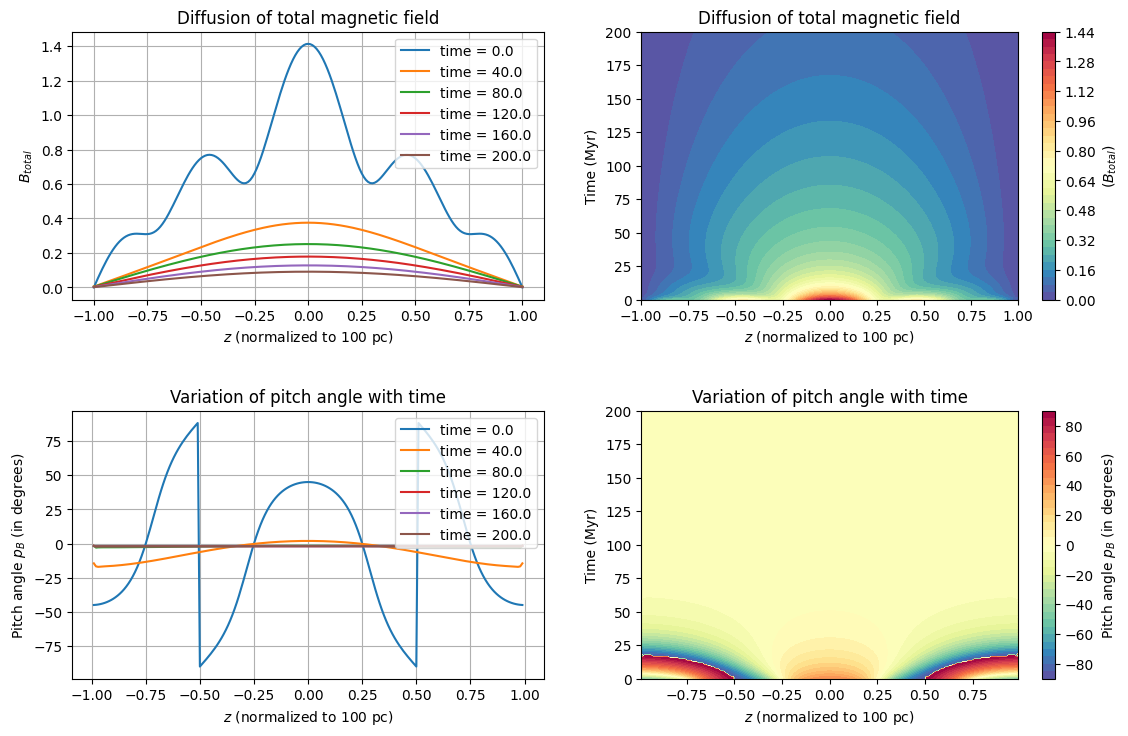

In [12]:
B_total, pitch = get_B_and_pitch(solution_r, solution_phi)

# Plot the total magnetic field and the pitch angle
plot_pitch(time_grid, spatial_grid, B_total, pitch)
plt.show()


One observes that there are the variations in the pitch angle are abrupt in this case. This is because there is change in the direction of the magnetic fields, causing the pitch angle to move from $+90^\circ$ to $-90^\circ$, which is natural. One must not think of this as code instability.


### Decay rate calculation

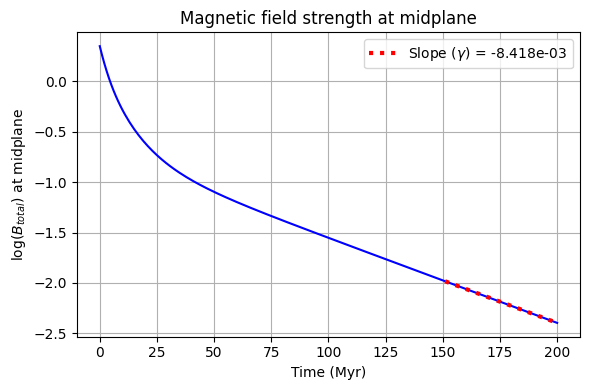

In [13]:
# Plot the decay of the magnetic field at the midplane
B_mid = np.log(B_total[int(len(spatial_grid)/2), :])
m, c = np.polyfit(time_grid[-50:], B_mid[-50:], 1)

plot_decay(time_grid, B_mid, m, c)
plt.show()


So the value of magnetic decay rate or decay constant obtained for this case is $\gamma = -8.418 \times 10^{-3}$

<hr><hr>